<a href="https://colab.research.google.com/github/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/course_project_template_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning in Human Language Technology Project

- Students names: Momina Iffat Iftikhar, Muhammad Junaid Raza
- Date: 12th Nov, 2025
- Chosen Corpus: Rotten Tomatoes
- Contributions (if group project):

### Corpus information

- Description of the chosen corpus: Movie Review Dataset containing 5,331 positive and 5,331 negative processed sentences from Rotten Tomatoes movie reviews for binary sentiment classification.
- Paper(s) and other published materials related to the corpus: Bo Pang and Lillian Lee, "Seeing stars: Exploiting class relationships for sentiment categorization with respect to rating scales", Proceedings of the ACL, 2005.
- Random baseline performance and expected performance for recent machine learned models: Random baseline: 50% (binary classification). Expected SOTA performance: ~85-90% accuracy based on transformer models.

---

## 1. Setup

In [1]:
# Your code to install and import libraries etc. here
# Section 1: Setup
# This cell installs and imports all necessary libraries

# Install required libraries
!pip install -q transformers datasets accelerate evaluate scikit-learn

# Core libraries
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import json

# Hugging Face libraries
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,           # For generative models (SmolLM, DistilGPT2)
    AutoModelForSequenceClassification,  # For BERT models
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding,
    pipeline
)
from datasets import load_dataset
import evaluate

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 38.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

---

## 2. Data download, sampling and preprocessing

### 2.1. Download the corpus

In [2]:
# Your code to download the corpus here
# Section 2.1: Download Rotten Tomatoes dataset

# Load dataset from Hugging Face Hub
dataset = load_dataset("rotten_tomatoes")

# Display dataset structure
print("Dataset structure:")
print(dataset)
print("\n" + "="*50 + "\n")

# Show example from each split
print("Example from training set:")
print(dataset['train'][0])
print("\n" + "="*50 + "\n")

# Display split sizes
print("Split sizes:")
for split in ['train', 'validation', 'test']:
    print(f"{split}: {len(dataset[split])} examples")

README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


Example from training set:
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


Split sizes:
train: 8530 examples
validation: 1066 examples
test: 1066 examples


### 2.2. Sampling and preprocessing

ROTTEN TOMATOES DATASET - LABEL DISTRIBUTION

TRAIN SET:
  Total examples: 8530
  Negative (0): 4265 (50.00%)
  Positive (1): 4265 (50.00%)
  Balance: BALANCED

VALIDATION SET:
  Total examples: 1066
  Negative (0): 533 (50.00%)
  Positive (1): 533 (50.00%)
  Balance: BALANCED

TEST SET:
  Total examples: 1066
  Negative (0): 533 (50.00%)
  Positive (1): 533 (50.00%)
  Balance: BALANCED



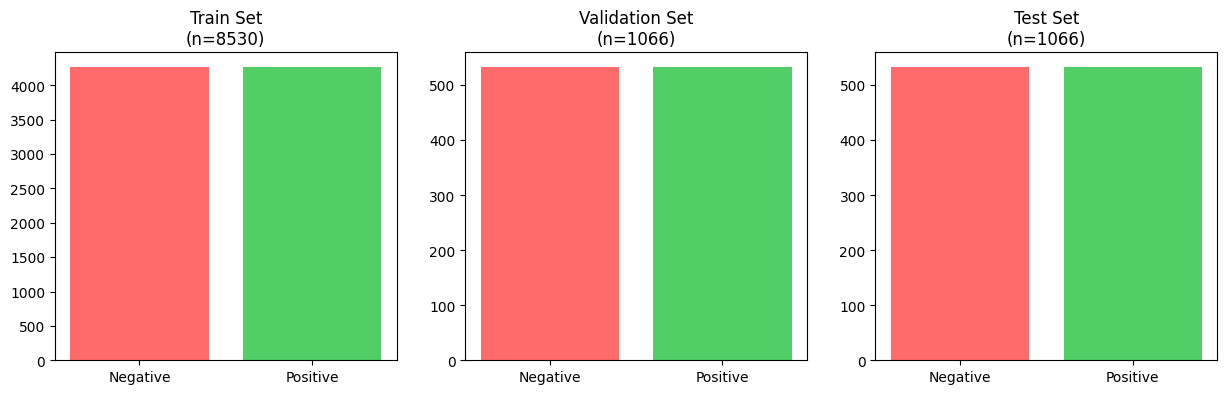

In [3]:
# Your code for any necessary sampling and preprocessing here

# =============================================================================

def analyze_label_distribution(dataset):
    """Analyze and visualize label distribution across all splits"""
    
    results = {}
    
    for split in ['train', 'validation', 'test']:
        labels = dataset[split]['label']
        label_counts = Counter(labels)
        
        results[split] = {
            'total': len(labels),
            'negative (0)': label_counts[0],
            'positive (1)': label_counts[1],
            'negative_pct': (label_counts[0] / len(labels)) * 100,
            'positive_pct': (label_counts[1] / len(labels)) * 100
        }
    
    return results

# Analyze distribution
distribution = analyze_label_distribution(dataset)

# Print statistics
print("="*70)
print("ROTTEN TOMATOES DATASET - LABEL DISTRIBUTION")
print("="*70)
for split, stats in distribution.items():
    print(f"\n{split.upper()} SET:")
    print(f"  Total examples: {stats['total']}")
    print(f"  Negative (0): {stats['negative (0)']} ({stats['negative_pct']:.2f}%)")
    print(f"  Positive (1): {stats['positive (1)']} ({stats['positive_pct']:.2f}%)")
    print(f"  Balance: {'BALANCED' if abs(stats['negative_pct'] - 50) < 5 else 'IMBALANCED'}")

print("\n" + "="*70)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, split in enumerate(['train', 'validation', 'test']):
    stats = distribution[split]
    axes[idx].bar(['Negative', 'Positive'], 
                  [stats['negative (0)'], stats['positive (1)']], 
                  color=['#ff6b6b', '#51cf66'])
    axes[idx].set_title(f'{split.capitalize()} Set\n(n={stats["total"]})')
    axes

---

## 3. Prompting a generative model (smolLM)

### 3.1 Prompt optimization

In [9]:
#common prompt based functions
# DEFINE PROMPTING FUNCTIONS
# =============================================================================

def create_prompt(text, examples=None):
    """
    Create a prompt for sentiment classification
    
    Args:
        text: The review text to classify
        examples: List of (text, label) tuples for few-shot examples (None for zero-shot)
    
    Returns:
        Formatted prompt string
    """
    
    # System instruction
    prompt = "Classify the sentiment of movie reviews as either 'positive' or 'negative'.\n\n"
    
    # Add few-shot examples if provided
    if examples:
        prompt += "Examples:\n"
        for ex_text, ex_label in examples:
            label_name = "positive" if ex_label == 1 else "negative"
            prompt += f"Review: {ex_text}\nSentiment: {label_name}\n\n"
    
    # Add the review to classify
    prompt += f"Review: {text}\nSentiment:"
    
    return prompt

def generate_prediction(model, tokenizer, prompt, max_new_tokens=10):
    """
    Generate prediction from the model
    
    Args:
        model: The language model
        tokenizer: The tokenizer
        prompt: Input prompt
        max_new_tokens: Maximum tokens to generate
    
    Returns:
        Generated text (just the completion, not the full prompt)
    """
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            #temperature=0.1,      # Low temperature for more deterministic outputs
            do_sample=False,      # Greedy decoding for consistency
            pad_token_id=tokenizer.pad_token_id
        )
    
    # Decode only the generated part (exclude the prompt)
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    
    return generated_text.strip()

def parse_sentiment(generated_text):
    """
    Parse the generated text to extract sentiment label
    
    Returns:
        0 for negative, 1 for positive, None if parsing fails
    """
    
    text_lower = generated_text.lower()
    
    # Check for clear positive/negative indicators
    if 'positive' in text_lower and 'negative' not in text_lower:
        return 1
    elif 'negative' in text_lower and 'positive' not in text_lower:
        return 0
    else:
        # Unparseable output
        return None

def evaluate_prompting(model, tokenizer, dataset_split, num_shots=0, num_samples=None):
    """
    Evaluate prompting approach on a dataset split
    
    Args:
        model: The language model
        tokenizer: The tokenizer
        dataset_split: Dataset split to evaluate on
        num_shots: Number of few-shot examples (0, 2, or 4)
        num_samples: Limit evaluation to N samples (None for all)
    
    Returns:
        Dictionary with results
    """
    
    # Select few-shot examples from training set (same for all test examples)
    few_shot_examples = None
    if num_shots > 0:
        # Select balanced examples (equal positive and negative)
        train_data = dataset['train']
        neg_examples = [(train_data[i]['text'], 0) for i in range(len(train_data)) if train_data[i]['label'] == 0]
        pos_examples = [(train_data[i]['text'], 1) for i in range(len(train_data)) if train_data[i]['label'] == 1]
        
        # Take first num_shots/2 from each class
        few_shot_examples = neg_examples[:num_shots//2] + pos_examples[:num_shots//2]
    
    # Limit samples if specified
    data = dataset_split if num_samples is None else dataset_split.select(range(min(num_samples, len(dataset_split))))
    
    predictions = []
    true_labels = []
    failed_parses = 0
    
    print(f"\nEvaluating {num_shots}-shot prompting on {len(data)} examples...")
    
    for example in tqdm(data):
        text = example['text']
        true_label = example['label']
        
        # Create prompt
        prompt = create_prompt(text, examples=few_shot_examples)
        
        # Generate prediction
        generated = generate_prediction(model, tokenizer, prompt)
        predicted_label = parse_sentiment(generated)
        
        # Track failed parses
        if predicted_label is None:
            failed_parses += 1
            # Default to majority class (0) for failed parses
            predicted_label = 0
        
        predictions.append(predicted_label)
        true_labels.append(true_label)
    
    # Calculate metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    accuracy = (predictions == true_labels).mean()
    
    # Per-class accuracy
    neg_mask = true_labels == 0
    pos_mask = true_labels == 1
    neg_accuracy = (predictions[neg_mask] == true_labels[neg_mask]).mean() if neg_mask.sum() > 0 else 0
    pos_accuracy = (predictions[pos_mask] == true_labels[pos_mask]).mean() if pos_mask.sum() > 0 else 0
    
    results = {
        'num_shots': num_shots,
        'accuracy': accuracy,
        'negative_accuracy': neg_accuracy,
        'positive_accuracy': pos_accuracy,
        'failed_parses': failed_parses,
        'failed_parse_rate': failed_parses / len(data),
        'predictions': predictions,
        'true_labels': true_labels
    }
    
    return results


In [5]:
# Your code and experiments relating to the prompt optimization here
# Section 3.1: Prompt Optimization for SmolLM-Instruct

# =============================================================================
# LOAD MODEL
# =============================================================================

print("Loading SmolLM-135M-Instruct...")
model_name = "HuggingFaceTB/SmolLM-135M-Instruct"

tokenizer_smol = AutoTokenizer.from_pretrained(model_name)
model_smol = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use FP16 for faster inference
    device_map="auto"            # Automatically use GPU
)

# Set padding token (required for batch processing)
if tokenizer_smol.pad_token is None:
    tokenizer_smol.pad_token = tokenizer_smol.eos_token
    model_smol.config.pad_token_id = tokenizer_smol.eos_token_id

print(f"Model loaded on: {model_smol.device}")
print(f"Model parameters: {model_smol.num_parameters() / 1e6:.1f}M")

# =============================================================================



# =============================================================================
# TEST DIFFERENT PROMPTING STRATEGIES ON VALIDATION SET
# =============================================================================

print("="*70)
print("PROMPT OPTIMIZATION ON VALIDATION SET")
print("="*70)

validation_results = {}

for num_shots in [0, 2, 4]:
    results = evaluate_prompting(
        model_smol, 
        tokenizer_smol, 
        dataset['validation'], 
        num_shots=num_shots
    )
    validation_results[num_shots] = results
    
    print(f"\n{num_shots}-shot Results:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Negative Accuracy: {results['negative_accuracy']:.4f}")
    print(f"  Positive Accuracy: {results['positive_accuracy']:.4f}")
    print(f"  Failed Parses: {results['failed_parses']} ({results['failed_parse_rate']:.2%})")

# =============================================================================
# SELECT BEST APPROACH
# =============================================================================

best_num_shots = max(validation_results.keys(), key=lambda k: validation_results[k]['accuracy'])
best_val_accuracy = validation_results[best_num_shots]['accuracy']

print("\n" + "="*70)
print(f"BEST APPROACH: {best_num_shots}-shot prompting")
print(f"Validation Accuracy: {best_val_accuracy:.4f}")
print("="*70)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
shots = list(validation_results.keys())
accuracies = [validation_results[s]['accuracy'] for s in shots]
ax1.plot(shots, accuracies, marker='o', linewidth=2, markersize=10, color='#4c72b0')
ax1.axhline(y=0.5, color='red', linestyle='--', label='Random Baseline (50%)', alpha=0.7)
ax1.set_xlabel('Number of Shots', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('SmolLM-Instruct: Prompting Performance on Validation Set', fontsize=13, fontweight='bold')
ax1.set_xticks(shots)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Failed parse rates
failed_rates = [validation_results[s]['failed_parse_rate'] for s in shots]
ax2.bar(shots, failed_rates, color='#dd8452', alpha=0.7)
ax2.set_xlabel('Number of Shots', fontsize=12)
ax2.set_ylabel('Failed Parse Rate', fontsize=12)
ax2.set_title('Failed Parse Rate by Prompting Strategy', fontsize=13, fontweight='bold')
ax2.set_xticks(shots)
ax2.set_ylim(0, max(failed_rates) * 1.2 if max(failed_rates) > 0 else 0.1)

plt.tight_layout()
plt.savefig('smol_prompting_validation.png', dpi=100, bbox_inches='tight')
plt.show()

Loading SmolLM-135M-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Model loaded on: cuda:0
Model parameters: 134.5M
PROMPT OPTIMIZATION ON VALIDATION SET

Evaluating 0-shot prompting on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 3.2 Evaluation on test set

In [ ]:
# Section 3.2: Evaluation on Test Set (SmolLM Prompting)

print("="*70)
print("SMOLLM-INSTRUCT: 4-SHOT PROMPTING - TEST SET EVALUATION")
print("="*70)

# Evaluate best approach on test set
test_results_smol_prompt = evaluate_prompting(
    model_smol, 
    tokenizer_smol, 
    dataset['test'], 
    num_shots=4  # Best approach from validation
)

print(f"\n{'='*70}")
print("FINAL TEST RESULTS:")
print(f"{'='*70}")
print(f"Accuracy: {test_results_smol_prompt['accuracy']:.4f}")
print(f"Negative Accuracy: {test_results_smol_prompt['negative_accuracy']:.4f}")
print(f"Positive Accuracy: {test_results_smol_prompt['positive_accuracy']:.4f}")
print(f"Failed Parses: {test_results_smol_prompt['failed_parses']} ({test_results_smol_prompt['failed_parse_rate']:.2%})")
print(f"{'='*70}")

# Store predictions for later error analysis (Section 8)
smol_prompt_predictions = {
    'model': 'SmolLM-Instruct (4-shot prompting)',
    'predictions': test_results_smol_prompt['predictions'],
    'true_labels': test_results_smol_prompt['true_labels'],
    'accuracy': test_results_smol_prompt['accuracy'],
    'failed_parses': test_results_smol_prompt['failed_parses']
}

# Save to file for persistence
with open('smol_prompt_predictions.pkl', 'wb') as f:
    pickle.dump(smol_prompt_predictions, f)

print("\n✓ Predictions saved for error analysis")

# Confusion Matrix


cm = confusion_matrix(test_results_smol_prompt['true_labels'], 
                      test_results_smol_prompt['predictions'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('SmolLM-Instruct (4-shot Prompting) - Test Set Confusion Matrix', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('smol_prompt_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(test_results_smol_prompt['true_labels'], 
                           test_results_smol_prompt['predictions'],
                           target_names=['Negative', 'Positive']))

# Clean up model from memory before next section
del model_smol
torch.cuda.empty_cache()
print("\n✓ Model removed from memory")

---

## 4. Fine-tuning a generative model

### 4.1. Model training

In [24]:
# MEMORY CLEANUP CELL - Run this before fine-tuning

import gc

# Clear Python memory
gc.collect()

# Clear CUDA cache
torch.cuda.empty_cache()

# Check memory status
if torch.cuda.is_available():
    print("GPU Memory Status:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    print(f"  Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated()) / 1e9:.2f} GB")
    
# Reset PyTorch
torch.cuda.reset_peak_memory_stats()
print("\n✓ Memory cleared")

GPU Memory Status:
  Allocated: 1.11 GB
  Cached: 2.31 GB
  Free: 14.72 GB

✓ Memory cleared


### 4.2 Hyperparameter optimization

✓ Memory cleared
Loading SmolLM-135M-Instruct for fine-tuning...
✓ Tokenizer loaded


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

✓ Formatted 8530 training examples

Example formatted text:
Review: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
Sentiment: positive<|im_end|>


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

✓ Datasets tokenized

Tokenization check:
Input IDs shape: 200
Labels shape: 200
Non-masked tokens: 59

HYPERPARAMETER SEARCH

Config: LR=1e-05, Batch=4 (eff: 16), Epochs=3
Starting training...


Epoch,Training Loss,Validation Loss
1,2.432600,4.982753
2,2.391700,4.858290
3,2.401600,4.846563


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



✓ Training completed successfully
Validation Loss: 4.8466
Training Loss: 2.4097
✓ New best model saved! (Val Loss: 4.8466)

Config: LR=1e-05, Batch=4 (eff: 16), Epochs=5
Starting training...


Epoch,Training Loss,Validation Loss
1,2.445800,4.991821
2,2.358500,4.783784
3,2.345900,4.726501
4,2.247900,4.724325
5,2.316200,4.728382


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t


✓ Training completed successfully
Validation Loss: 4.7243
Training Loss: 2.3515
✓ New best model saved! (Val Loss: 4.7243)

Config: LR=3e-05, Batch=4 (eff: 16), Epochs=3
Starting training...


Epoch,Training Loss,Validation Loss
1,1.855000,3.727283
2,1.796500,3.614699
3,1.804500,3.603299


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



✓ Training completed successfully
Validation Loss: 3.6033
Training Loss: 1.8960
✓ New best model saved! (Val Loss: 3.6033)

Config: LR=3e-05, Batch=4 (eff: 16), Epochs=5
Starting training...


Epoch,Training Loss,Validation Loss
1,1.867400,3.711807
2,1.756200,3.527528
3,1.757800,3.503251
4,1.668600,3.498848
5,1.730400,3.497874


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t


✓ Training completed successfully
Validation Loss: 3.4979
Training Loss: 1.8199
✓ New best model saved! (Val Loss: 3.4979)

HYPERPARAMETER SEARCH RESULTS
     lr  batch_size  num_epochs  val_loss  train_loss
0.00003 4 (eff: 16)           5  3.497874    1.819906
0.00003 4 (eff: 16)           3  3.603299    1.895984
0.00001 4 (eff: 16)           5  4.724325    2.351489
0.00001 4 (eff: 16)           3  4.846563    2.409716

BEST HYPERPARAMETERS:
Learning Rate: 3e-05
Batch Size: 4 (effective: 16)
Epochs: 5
Validation Loss: 3.4979


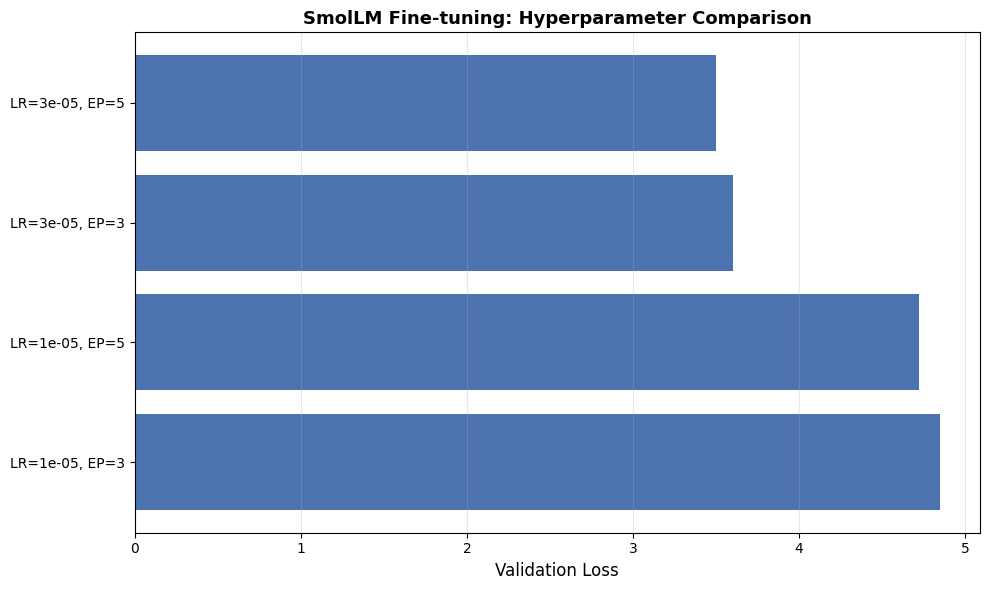


✓ Section 4 complete!


In [26]:
# Section 4.1 & 4.2: Fine-tuning SmolLM (SIMPLIFIED & STABLE)

# =============================================================================
# MEMORY CLEANUP FIRST
# =============================================================================
import gc
gc.collect()
torch.cuda.empty_cache()
print("✓ Memory cleared")

# =============================================================================
# RELOAD MODEL AND TOKENIZER
# =============================================================================
print("Loading SmolLM-135M-Instruct for fine-tuning...")
model_name = "HuggingFaceTB/SmolLM-135M-Instruct"

tokenizer_smol_ft = AutoTokenizer.from_pretrained(model_name)
if tokenizer_smol_ft.pad_token is None:
    tokenizer_smol_ft.pad_token = tokenizer_smol_ft.eos_token

print("✓ Tokenizer loaded")

# =============================================================================
# SIMPLIFIED DATA FORMATTING (More stable for training)
# =============================================================================

def format_simple_instruction(examples):
    """
    Simplified format: shorter prompts, clearer structure
    Format: "Review: [TEXT]\nSentiment: [LABEL]<eos>"
    """
    texts = []
    for text, label in zip(examples['text'], examples['label']):
        sentiment = "positive" if label == 1 else "negative"
        # Simpler format
        formatted = f"Review: {text}\nSentiment: {sentiment}{tokenizer_smol_ft.eos_token}"
        texts.append(formatted)
    return {"formatted_text": texts}

# Apply formatting
train_dataset_ft = dataset['train'].map(format_simple_instruction, batched=True)
val_dataset_ft = dataset['validation'].map(format_simple_instruction, batched=True)
test_dataset_ft = dataset['test'].map(format_simple_instruction, batched=True)

print(f"✓ Formatted {len(train_dataset_ft)} training examples")
print(f"\nExample formatted text:\n{train_dataset_ft[0]['formatted_text']}")

# =============================================================================
# TOKENIZATION (Simpler masking strategy)
# =============================================================================

def tokenize_function_simple(examples):
    """
    Tokenize with simpler masking strategy
    Only mask padding, train on everything else
    """
    tokenized = tokenizer_smol_ft(
        examples['formatted_text'],
        truncation=True,
        max_length=200,  # Reduced from 256
        padding='max_length',
        return_tensors=None
    )
    
    # Mask only padding tokens
    labels = []
    for input_ids in tokenized['input_ids']:
        label_ids = [
            (token_id if token_id != tokenizer_smol_ft.pad_token_id else -100)
            for token_id in input_ids
        ]
        labels.append(label_ids)
    
    tokenized['labels'] = labels
    return tokenized

train_tokenized = train_dataset_ft.map(tokenize_function_simple, batched=True, remove_columns=train_dataset_ft.column_names)
val_tokenized = val_dataset_ft.map(tokenize_function_simple, batched=True, remove_columns=val_dataset_ft.column_names)
test_tokenized = test_dataset_ft.map(tokenize_function_simple, batched=True, remove_columns=test_dataset_ft.column_names)

print("✓ Datasets tokenized")

# Verify tokenization (debugging)
print("\nTokenization check:")
sample = train_tokenized[0]
print(f"Input IDs shape: {len(sample['input_ids'])}")
print(f"Labels shape: {len(sample['labels'])}")
print(f"Non-masked tokens: {sum(1 for x in sample['labels'] if x != -100)}")

# =============================================================================
# HYPERPARAMETER SEARCH (More conservative settings)
# =============================================================================

print("\n" + "="*70)
print("HYPERPARAMETER SEARCH")
print("="*70)

# Conservative hyperparameters to avoid NaN
learning_rates = [1e-5, 3e-5]  # Lower learning rates
batch_sizes = [4]
num_epochs_list = [3, 5]

best_val_loss = float('inf')
best_hyperparams = None
hyperparameter_results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in num_epochs_list:
            
            print(f"\n{'='*70}")
            print(f"Config: LR={lr}, Batch={batch_size} (eff: 16), Epochs={num_epochs}")
            print(f"{'='*70}")
            
            # Load fresh model
            model_ft = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
                device_map="auto"
            )
            
            # More conservative training arguments
            training_args = TrainingArguments(
                output_dir=f"./smol_ft_lr{lr}_bs{batch_size}_ep{num_epochs}",
                learning_rate=lr,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                gradient_accumulation_steps=4,
                num_train_epochs=num_epochs,
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="eval_loss",
                logging_steps=50,
                logging_first_step=True,  # See loss from start
                save_total_limit=1,
                bf16=torch.cuda.is_bf16_supported(),
                fp16=not torch.cuda.is_bf16_supported(),
                report_to="none",
                disable_tqdm=False,
                gradient_checkpointing=True,
                optim="adamw_torch",
                max_grad_norm=0.5,  # More aggressive clipping
                warmup_ratio=0.1,  # 10% warmup
                weight_decay=0.01,
            )
            
            # Initialize Trainer
            trainer = Trainer(
                model=model_ft,
                args=training_args,
                train_dataset=train_tokenized,
                eval_dataset=val_tokenized,
                processing_class=tokenizer_smol_ft,  # Use processing_class instead of tokenizer
            )
            
            # Train with error handling
            try:
                print("Starting training...")
                train_result = trainer.train()
                
                # Check for NaN
                if np.isnan(train_result.training_loss):
                    print("⚠️ NaN detected in training loss! Skipping this config.")
                    continue
                
                # Evaluate
                eval_result = trainer.evaluate()
                val_loss = eval_result['eval_loss']
                
                # Check for NaN in validation
                if np.isnan(val_loss):
                    print("⚠️ NaN detected in validation loss! Skipping this config.")
                    continue
                
                print(f"\n✓ Training completed successfully")
                print(f"Validation Loss: {val_loss:.4f}")
                print(f"Training Loss: {train_result.training_loss:.4f}")
                
                # Store results
                hyperparameter_results.append({
                    'lr': lr,
                    'batch_size': f"{batch_size} (eff: 16)",
                    'num_epochs': num_epochs,
                    'val_loss': val_loss,
                    'train_loss': train_result.training_loss
                })
                
                # Track best
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_hyperparams = {
                        'lr': lr,
                        'batch_size': batch_size,
                        'num_epochs': num_epochs
                    }
                    trainer.save_model("./smol_ft_best_model")
                    tokenizer_smol_ft.save_pretrained("./smol_ft_best_model")
                    print(f"✓ New best model saved! (Val Loss: {val_loss:.4f})")
                
            except Exception as e:
                print(f"⚠️ Error during training: {e}")
                print("Skipping this configuration...")
            
            finally:
                # CLEANUP
                del model_ft
                del trainer
                torch.cuda.empty_cache()
                gc.collect()

# =============================================================================
# RESULTS
# =============================================================================

if len(hyperparameter_results) == 0:
    print("\n❌ All configurations failed! Need to debug further.")
else:
    print("\n" + "="*70)
    print("HYPERPARAMETER SEARCH RESULTS")
    print("="*70)
    
    results_df = pd.DataFrame(hyperparameter_results)
    results_df = results_df.sort_values('val_loss')
    print(results_df.to_string(index=False))
    
    print(f"\n{'='*70}")
    print("BEST HYPERPARAMETERS:")
    print(f"{'='*70}")
    print(f"Learning Rate: {best_hyperparams['lr']}")
    print(f"Batch Size: {best_hyperparams['batch_size']} (effective: 16)")
    print(f"Epochs: {best_hyperparams['num_epochs']}")
    print(f"Validation Loss: {best_val_loss:.4f}")
    print(f"{'='*70}")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    configs = [f"LR={r['lr']}, EP={r['num_epochs']}" for _, r in results_df.iterrows()]
    ax.barh(range(len(results_df)), results_df['val_loss'], color='#4c72b0')
    ax.set_yticks(range(len(results_df)))
    ax.set_yticklabels(configs, fontsize=10)
    ax.set_xlabel('Validation Loss', fontsize=12)
    ax.set_title('SmolLM Fine-tuning: Hyperparameter Comparison', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('smol_ft_hyperparameter_search.png', dpi=100, bbox_inches='tight')
    plt.show()

print("\n✓ Section 4 complete!")

### 4.3. Evaluation on test set

In [27]:
# Your code to evaluate the final model on the test set here
# Section 4.3: Test Evaluation (SmolLM Fine-tuned)

print("="*70)
print("SMOLLM-INSTRUCT FINE-TUNED - TEST SET EVALUATION")
print("="*70)

# Load best fine-tuned model
model_smol_finetuned = AutoModelForCausalLM.from_pretrained(
    "./smol_ft_best_model",
    torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    device_map="auto"
)
tokenizer_smol_finetuned = AutoTokenizer.from_pretrained("./smol_ft_best_model")

print("✓ Best fine-tuned model loaded")

# =============================================================================
# EVALUATION FUNCTION FOR FINE-TUNED MODEL
# =============================================================================

def evaluate_finetuned_model(model, tokenizer, dataset_split):
    """Evaluate fine-tuned model on test set"""
    
    predictions = []
    true_labels = []
    failed_parses = 0
    
    print(f"\nEvaluating on {len(dataset_split)} examples...")
    
    for example in tqdm(dataset_split):
        text = example['text']
        true_label = example['label']
        
        # Create prompt (same format as training)
        prompt = f"Review: {text}\nSentiment:"
        
        # Generate
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=200).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id
            )
        
        # Decode
        generated = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).strip()
        
        # Parse sentiment
        predicted_label = parse_sentiment(generated)
        
        if predicted_label is None:
            failed_parses += 1
            predicted_label = 0  # Default
        
        predictions.append(predicted_label)
        true_labels.append(true_label)
    
    # Calculate metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean()
    
    results = {
        'accuracy': accuracy,
        'failed_parses': failed_parses,
        'failed_parse_rate': failed_parses / len(dataset_split),
        'predictions': predictions,
        'true_labels': true_labels
    }
    
    return results

# Evaluate on test set
test_results_smol_ft = evaluate_finetuned_model(
    model_smol_finetuned,
    tokenizer_smol_finetuned,
    dataset['test']
)

print(f"\n{'='*70}")
print("FINAL TEST RESULTS:")
print(f"{'='*70}")
print(f"Accuracy: {test_results_smol_ft['accuracy']:.4f}")
print(f"Failed Parses: {test_results_smol_ft['failed_parses']} ({test_results_smol_ft['failed_parse_rate']:.2%})")
print(f"{'='*70}")

# Store for error analysis
smol_ft_predictions = {
    'model': 'SmolLM-Instruct (fine-tuned)',
    'predictions': test_results_smol_ft['predictions'],
    'true_labels': test_results_smol_ft['true_labels'],
    'accuracy': test_results_smol_ft['accuracy'],
    'failed_parses': test_results_smol_ft['failed_parses']
}

with open('smol_ft_predictions.pkl', 'wb') as f:
    pickle.dump(smol_ft_predictions, f)

print("\n✓ Predictions saved for error analysis")

# Comparison with prompting
print("\n" + "="*70)
print("SMOLLM COMPARISON: PROMPTING vs FINE-TUNING")
print("="*70)
print(f"Prompting (4-shot):    {smol_prompt_predictions['accuracy']:.4f} accuracy")
print(f"Fine-tuning:           {test_results_smol_ft['accuracy']:.4f} accuracy")
print(f"Difference:            {(test_results_smol_ft['accuracy'] - smol_prompt_predictions['accuracy']):.4f}")
if test_results_smol_ft['accuracy'] < smol_prompt_predictions['accuracy']:
    print("⚠️  Fine-tuning underperformed prompting for SmolLM")
print("="*70)

# Cleanup
del model_smol_finetuned
torch.cuda.empty_cache()
print("\n✓ Model removed from memory")

SMOLLM-INSTRUCT FINE-TUNED - TEST SET EVALUATION
✓ Best fine-tuned model loaded

Evaluating on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]


FINAL TEST RESULTS:
Accuracy: 0.7242
Failed Parses: 1 (0.09%)

✓ Predictions saved for error analysis

SMOLLM COMPARISON: PROMPTING vs FINE-TUNING
Prompting (4-shot):    0.7308 accuracy
Fine-tuning:           0.7242 accuracy
Difference:            -0.0066
⚠️  Fine-tuning underperformed prompting for SmolLM

✓ Model removed from memory


---

## 3. Prompting a generative model (DistilGPT2)

### 3.1 Prompt optimization

### 3.2 Evaluation on test set

✓ Memory cleared
Loading DistilGPT2...
Model loaded on: cuda:0
Model parameters: 81.9M
DISTILGPT2 PROMPT OPTIMIZATION ON VALIDATION SET

Evaluating 0-shot prompting on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]


0-shot Results:
  Accuracy: 0.5122
  Negative Accuracy: 0.9737
  Positive Accuracy: 0.0507
  Failed Parses: 1003 (94.09%)

Evaluating 2-shot prompting on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]


2-shot Results:
  Accuracy: 0.5450
  Negative Accuracy: 0.9287
  Positive Accuracy: 0.1614
  Failed Parses: 4 (0.38%)

Evaluating 4-shot prompting on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]


4-shot Results:
  Accuracy: 0.5150
  Negative Accuracy: 0.9944
  Positive Accuracy: 0.0356
  Failed Parses: 13 (1.22%)

BEST APPROACH: 2-shot prompting
Validation Accuracy: 0.5450


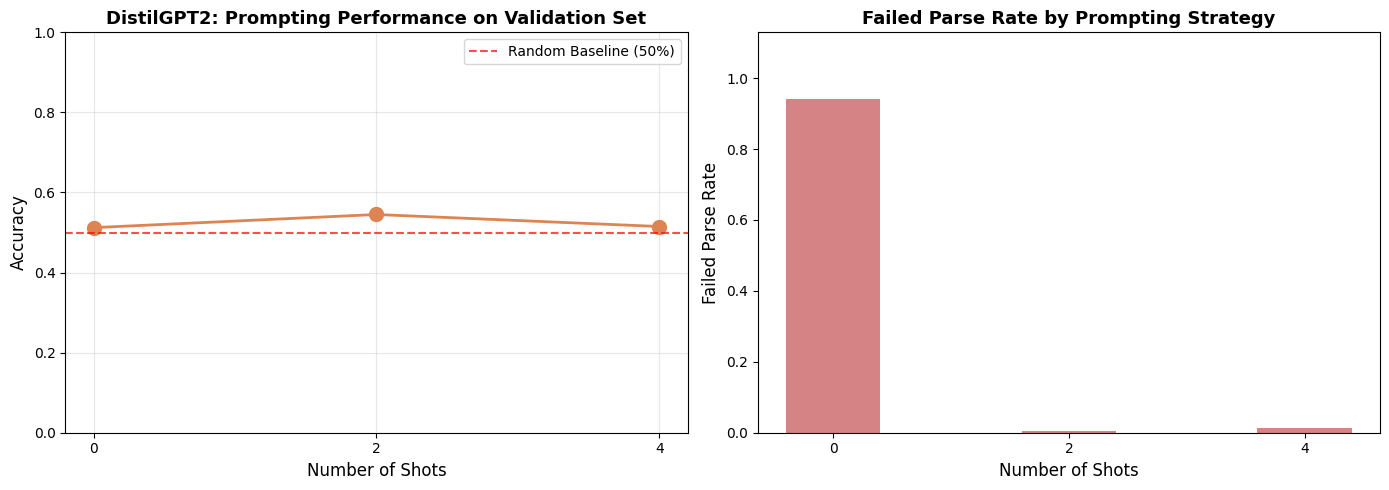


DISTILGPT2: 2-SHOT PROMPTING - TEST SET EVALUATION

Evaluating 2-shot prompting on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]


FINAL TEST RESULTS:
Accuracy: 0.5310
Negative Accuracy: 0.9362
Positive Accuracy: 0.1257
Failed Parses: 6 (0.56%)

✓ Predictions saved for error analysis


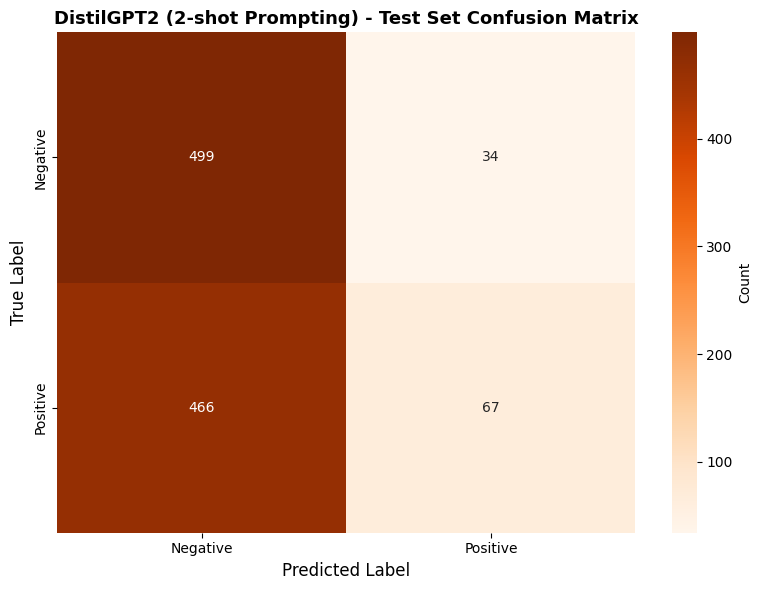


✓ Model removed from memory


In [14]:
# Section 6a: Bonus Task - DistilGPT2 Prompting

# =============================================================================
# MEMORY CLEANUP
# =============================================================================
import gc
gc.collect()
torch.cuda.empty_cache()
print("✓ Memory cleared")

# =============================================================================
# LOAD DISTILGPT2 MODEL
# =============================================================================

print("Loading DistilGPT2...")
model_name_gpt2 = "distilbert/distilgpt2"

tokenizer_gpt2 = AutoTokenizer.from_pretrained(model_name_gpt2)
model_gpt2 = AutoModelForCausalLM.from_pretrained(
    model_name_gpt2,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Set padding token
if tokenizer_gpt2.pad_token is None:
    tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token
    model_gpt2.config.pad_token_id = tokenizer_gpt2.eos_token_id

print(f"Model loaded on: {model_gpt2.device}")
print(f"Model parameters: {model_gpt2.num_parameters() / 1e6:.1f}M")

# =============================================================================
# PROMPTING FUNCTIONS (Reusing from SmolLM, same logic)
# =============================================================================

def create_prompt_gpt2(text, examples=None):
    """
    Create prompt for DistilGPT2
    Note: DistilGPT2 is NOT instruction-tuned, so simpler prompts may work better
    """
    
    # Simple instruction
    prompt = "Classify movie review sentiment as positive or negative.\n\n"
    
    # Add few-shot examples
    if examples:
        prompt += "Examples:\n"
        for ex_text, ex_label in examples:
            label_name = "positive" if ex_label == 1 else "negative"
            prompt += f"Review: {ex_text}\nSentiment: {label_name}\n\n"
    
    # Add review to classify
    prompt += f"Review: {text}\nSentiment:"
    
    return prompt


def generate_prediction_gpt2(model, tokenizer, prompt, max_new_tokens=10):
    """Generate prediction from DistilGPT2"""
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # Greedy decoding
            pad_token_id=tokenizer.pad_token_id
        )
    
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return generated_text.strip()


# Reuse parse_sentiment function from earlier
# def parse_sentiment(generated_text): ... (already defined)


def evaluate_prompting_gpt2(model, tokenizer, dataset_split, num_shots=0, num_samples=None):
    """Evaluate DistilGPT2 prompting"""
    
    # Select few-shot examples
    few_shot_examples = None
    if num_shots > 0:
        train_data = dataset['train']
        neg_examples = [(train_data[i]['text'], 0) for i in range(len(train_data)) if train_data[i]['label'] == 0]
        pos_examples = [(train_data[i]['text'], 1) for i in range(len(train_data)) if train_data[i]['label'] == 1]
        few_shot_examples = neg_examples[:num_shots//2] + pos_examples[:num_shots//2]
    
    # Limit samples if specified
    data = dataset_split if num_samples is None else dataset_split.select(range(min(num_samples, len(dataset_split))))
    
    predictions = []
    true_labels = []
    failed_parses = 0
    
    print(f"\nEvaluating {num_shots}-shot prompting on {len(data)} examples...")
    
    for example in tqdm(data):
        text = example['text']
        true_label = example['label']
        
        # Create prompt
        prompt = create_prompt_gpt2(text, examples=few_shot_examples)
        
        # Generate
        generated = generate_prediction_gpt2(model, tokenizer, prompt)
        predicted_label = parse_sentiment(generated)
        
        if predicted_label is None:
            failed_parses += 1
            predicted_label = 0
        
        predictions.append(predicted_label)
        true_labels.append(true_label)
    
    # Calculate metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean()
    
    neg_mask = true_labels == 0
    pos_mask = true_labels == 1
    neg_accuracy = (predictions[neg_mask] == true_labels[neg_mask]).mean() if neg_mask.sum() > 0 else 0
    pos_accuracy = (predictions[pos_mask] == true_labels[pos_mask]).mean() if pos_mask.sum() > 0 else 0
    
    results = {
        'num_shots': num_shots,
        'accuracy': accuracy,
        'negative_accuracy': neg_accuracy,
        'positive_accuracy': pos_accuracy,
        'failed_parses': failed_parses,
        'failed_parse_rate': failed_parses / len(data),
        'predictions': predictions,
        'true_labels': true_labels
    }
    
    return results

# =============================================================================
# TEST PROMPTING STRATEGIES ON VALIDATION SET
# =============================================================================

print("="*70)
print("DISTILGPT2 PROMPT OPTIMIZATION ON VALIDATION SET")
print("="*70)

validation_results_gpt2 = {}

for num_shots in [0, 2, 4]:
    results = evaluate_prompting_gpt2(
        model_gpt2,
        tokenizer_gpt2,
        dataset['validation'],
        num_shots=num_shots
    )
    validation_results_gpt2[num_shots] = results
    
    print(f"\n{num_shots}-shot Results:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Negative Accuracy: {results['negative_accuracy']:.4f}")
    print(f"  Positive Accuracy: {results['positive_accuracy']:.4f}")
    print(f"  Failed Parses: {results['failed_parses']} ({results['failed_parse_rate']:.2%})")

# =============================================================================
# SELECT BEST APPROACH
# =============================================================================

best_num_shots_gpt2 = max(validation_results_gpt2.keys(), key=lambda k: validation_results_gpt2[k]['accuracy'])
best_val_accuracy_gpt2 = validation_results_gpt2[best_num_shots_gpt2]['accuracy']

print("\n" + "="*70)
print(f"BEST APPROACH: {best_num_shots_gpt2}-shot prompting")
print(f"Validation Accuracy: {best_val_accuracy_gpt2:.4f}")
print("="*70)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
shots = list(validation_results_gpt2.keys())
accuracies = [validation_results_gpt2[s]['accuracy'] for s in shots]
ax1.plot(shots, accuracies, marker='o', linewidth=2, markersize=10, color='#dd8452')
ax1.axhline(y=0.5, color='red', linestyle='--', label='Random Baseline (50%)', alpha=0.7)
ax1.set_xlabel('Number of Shots', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('DistilGPT2: Prompting Performance on Validation Set', fontsize=13, fontweight='bold')
ax1.set_xticks(shots)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Failed parse rates
failed_rates = [validation_results_gpt2[s]['failed_parse_rate'] for s in shots]
ax2.bar(shots, failed_rates, color='#c44e52', alpha=0.7)
ax2.set_xlabel('Number of Shots', fontsize=12)
ax2.set_ylabel('Failed Parse Rate', fontsize=12)
ax2.set_title('Failed Parse Rate by Prompting Strategy', fontsize=13, fontweight='bold')
ax2.set_xticks(shots)
ax2.set_ylim(0, max(failed_rates) * 1.2 if max(failed_rates) > 0 else 0.1)

plt.tight_layout()
plt.savefig('distilgpt2_prompting_validation.png', dpi=100, bbox_inches='tight')
plt.show()

# =============================================================================
# EVALUATE BEST APPROACH ON TEST SET
# =============================================================================

print("\n" + "="*70)
print(f"DISTILGPT2: {best_num_shots_gpt2}-SHOT PROMPTING - TEST SET EVALUATION")
print("="*70)

test_results_gpt2_prompt = evaluate_prompting_gpt2(
    model_gpt2,
    tokenizer_gpt2,
    dataset['test'],
    num_shots=best_num_shots_gpt2
)

print(f"\n{'='*70}")
print("FINAL TEST RESULTS:")
print(f"{'='*70}")
print(f"Accuracy: {test_results_gpt2_prompt['accuracy']:.4f}")
print(f"Negative Accuracy: {test_results_gpt2_prompt['negative_accuracy']:.4f}")
print(f"Positive Accuracy: {test_results_gpt2_prompt['positive_accuracy']:.4f}")
print(f"Failed Parses: {test_results_gpt2_prompt['failed_parses']} ({test_results_gpt2_prompt['failed_parse_rate']:.2%})")
print(f"{'='*70}")

# Store for error analysis
gpt2_prompt_predictions = {
    'model': f'DistilGPT2 ({best_num_shots_gpt2}-shot prompting)',
    'predictions': test_results_gpt2_prompt['predictions'],
    'true_labels': test_results_gpt2_prompt['true_labels'],
    'accuracy': test_results_gpt2_prompt['accuracy'],
    'failed_parses': test_results_gpt2_prompt['failed_parses']
}

with open('gpt2_prompt_predictions.pkl', 'wb') as f:
    pickle.dump(gpt2_prompt_predictions, f)

print("\n✓ Predictions saved for error analysis")

# Confusion Matrix
cm = confusion_matrix(test_results_gpt2_prompt['true_labels'], 
                      test_results_gpt2_prompt['predictions'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'DistilGPT2 ({best_num_shots_gpt2}-shot Prompting) - Test Set Confusion Matrix',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('distilgpt2_prompt_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

# Cleanup
del model_gpt2
torch.cuda.empty_cache()
print("\n✓ Model removed from memory")

---

## 4. Fine-tuning a generative model

### 4.1. Model training

In [15]:
# DistilGPT2 Fine-tuning

# =============================================================================
# MEMORY CLEANUP
# =============================================================================
import gc
gc.collect()
torch.cuda.empty_cache()
print("✓ Memory cleared")

# =============================================================================
# LOAD DISTILGPT2 FOR FINE-TUNING
# =============================================================================

print("Loading DistilGPT2 for fine-tuning...")
model_name_gpt2 = "distilbert/distilgpt2"

tokenizer_gpt2_ft = AutoTokenizer.from_pretrained(model_name_gpt2)
if tokenizer_gpt2_ft.pad_token is None:
    tokenizer_gpt2_ft.pad_token = tokenizer_gpt2_ft.eos_token

print("✓ Tokenizer loaded")
print(f"Model size: ~82M parameters (vs SmolLM's 135M)")

# =============================================================================
# PREPARE DATASET (Same format as SmolLM)
# =============================================================================

def format_simple_instruction_gpt2(examples):
    """Simplified format for DistilGPT2"""
    texts = []
    for text, label in zip(examples['text'], examples['label']):
        sentiment = "positive" if label == 1 else "negative"
        formatted = f"Review: {text}\nSentiment: {sentiment}{tokenizer_gpt2_ft.eos_token}"
        texts.append(formatted)
    return {"formatted_text": texts}

# Format datasets
train_dataset_gpt2_ft = dataset['train'].map(format_simple_instruction_gpt2, batched=True)
val_dataset_gpt2_ft = dataset['validation'].map(format_simple_instruction_gpt2, batched=True)
test_dataset_gpt2_ft = dataset['test'].map(format_simple_instruction_gpt2, batched=True)

print(f"✓ Formatted {len(train_dataset_gpt2_ft)} training examples")
print(f"\nExample:\n{train_dataset_gpt2_ft[0]['formatted_text']}")

# =============================================================================
# TOKENIZATION
# =============================================================================

def tokenize_function_gpt2(examples):
    """Tokenize for DistilGPT2"""
    tokenized = tokenizer_gpt2_ft(
        examples['formatted_text'],
        truncation=True,
        max_length=200,
        padding='max_length',
        return_tensors=None
    )
    
    # Mask only padding tokens
    labels = []
    for input_ids in tokenized['input_ids']:
        label_ids = [
            (token_id if token_id != tokenizer_gpt2_ft.pad_token_id else -100)
            for token_id in input_ids
        ]
        labels.append(label_ids)
    
    tokenized['labels'] = labels
    return tokenized

train_tokenized_gpt2 = train_dataset_gpt2_ft.map(tokenize_function_gpt2, batched=True, remove_columns=train_dataset_gpt2_ft.column_names)
val_tokenized_gpt2 = val_dataset_gpt2_ft.map(tokenize_function_gpt2, batched=True, remove_columns=val_dataset_gpt2_ft.column_names)
test_tokenized_gpt2 = test_dataset_gpt2_ft.map(tokenize_function_gpt2, batched=True, remove_columns=test_dataset_gpt2_ft.column_names)

print("✓ Datasets tokenized")



✓ Memory cleared
Loading DistilGPT2 for fine-tuning...
✓ Tokenizer loaded
Model size: ~82M parameters (vs SmolLM's 135M)


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

✓ Formatted 8530 training examples

Example:
Review: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
Sentiment: positive<|endoftext|>


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

✓ Datasets tokenized


### 4.2 Hyperparameter optimization


DISTILGPT2 HYPERPARAMETER SEARCH

Config: LR=1e-05, Batch=4 (eff: 16), Epochs=3
Starting training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,2.409900,4.751588
2,2.377400,4.648488
3,2.388700,4.636801


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



✓ Training completed
Validation Loss: 4.6368
Training Loss: 2.3951
✓ New best model saved! (Val Loss: 4.6368)

Config: LR=1e-05, Batch=4 (eff: 16), Epochs=5
Starting training...


Epoch,Training Loss,Validation Loss
1,2.422500,4.755746
2,2.342500,4.559252
3,2.327900,4.514073
4,2.223900,4.505536
5,2.292900,4.504412


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t


✓ Training completed
Validation Loss: 4.5044
Training Loss: 2.3335
✓ New best model saved! (Val Loss: 4.5044)

Config: LR=3e-05, Batch=4 (eff: 16), Epochs=3
Starting training...


Epoch,Training Loss,Validation Loss
1,1.956600,3.807304
2,1.926800,3.720345
3,1.933900,3.715293


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



✓ Training completed
Validation Loss: 3.7153
Training Loss: 1.9951
✓ New best model saved! (Val Loss: 3.7153)

Config: LR=3e-05, Batch=4 (eff: 16), Epochs=5
Starting training...


Epoch,Training Loss,Validation Loss
1,1.965900,3.802275
2,1.905800,3.667786
3,1.902300,3.646590
4,1.808500,3.641522
5,1.873100,3.640865


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t


✓ Training completed
Validation Loss: 3.6409
Training Loss: 1.9406
✓ New best model saved! (Val Loss: 3.6409)

HYPERPARAMETER SEARCH RESULTS
     lr  batch_size  num_epochs  val_loss  train_loss
0.00003 4 (eff: 16)           5  3.640865    1.940566
0.00003 4 (eff: 16)           3  3.715293    1.995074
0.00001 4 (eff: 16)           5  4.504412    2.333493
0.00001 4 (eff: 16)           3  4.636801    2.395094

BEST HYPERPARAMETERS:
Learning Rate: 3e-05
Batch Size: 4 (effective: 16)
Epochs: 5
Validation Loss: 3.6409


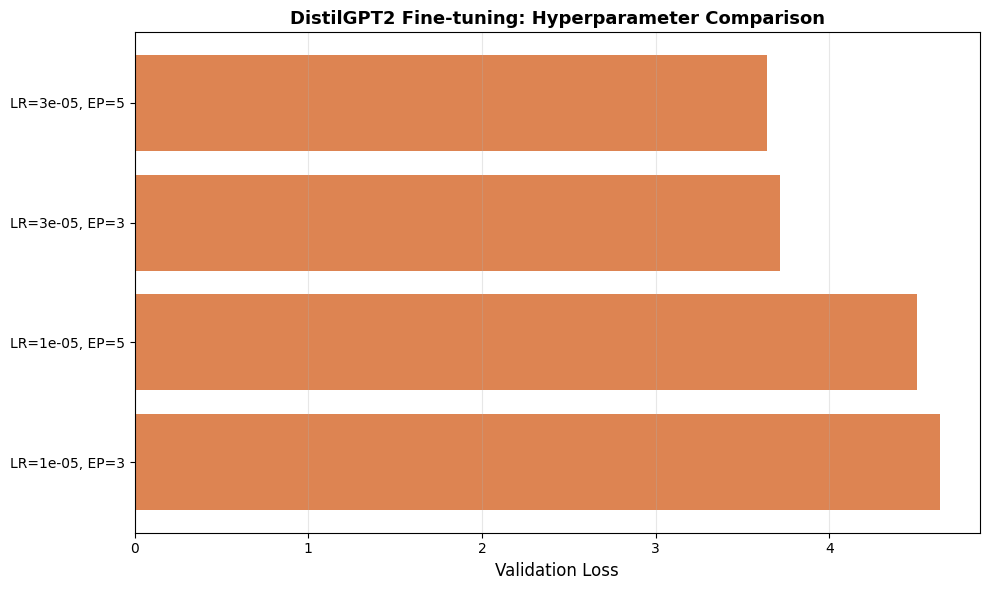


✓ DistilGPT2 fine-tuning complete!


In [16]:
# HYPERPARAMETER SEARCH
# =============================================================================

print("\n" + "="*70)
print("DISTILGPT2 HYPERPARAMETER SEARCH")
print("="*70)

# Conservative hyperparameters (learned from SmolLM)
learning_rates = [1e-5, 3e-5]
batch_sizes = [4]
num_epochs_list = [3, 5]

best_val_loss_gpt2 = float('inf')
best_hyperparams_gpt2 = None
hyperparameter_results_gpt2 = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in num_epochs_list:
            
            print(f"\n{'='*70}")
            print(f"Config: LR={lr}, Batch={batch_size} (eff: 16), Epochs={num_epochs}")
            print(f"{'='*70}")
            
            # Load fresh model
            model_gpt2_ft = AutoModelForCausalLM.from_pretrained(
                model_name_gpt2,
                torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
                device_map="auto"
            )
            
            # Training arguments (same stable config as SmolLM)
            training_args = TrainingArguments(
                output_dir=f"./gpt2_ft_lr{lr}_bs{batch_size}_ep{num_epochs}",
                learning_rate=lr,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                gradient_accumulation_steps=4,
                num_train_epochs=num_epochs,
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="eval_loss",
                logging_steps=50,
                logging_first_step=True,
                save_total_limit=1,
                bf16=torch.cuda.is_bf16_supported(),
                fp16=not torch.cuda.is_bf16_supported(),
                report_to="none",
                disable_tqdm=False,
                gradient_checkpointing=True,
                optim="adamw_torch",
                max_grad_norm=0.5,
                warmup_ratio=0.1,
                weight_decay=0.01,
            )
            
            # Initialize Trainer
            trainer = Trainer(
                model=model_gpt2_ft,
                args=training_args,
                train_dataset=train_tokenized_gpt2,
                eval_dataset=val_tokenized_gpt2,
                processing_class=tokenizer_gpt2_ft,
            )
            
            # Train with error handling
            try:
                print("Starting training...")
                train_result = trainer.train()
                
                # Check for NaN
                if np.isnan(train_result.training_loss):
                    print("⚠️ NaN in training loss! Skipping.")
                    continue
                
                # Evaluate
                eval_result = trainer.evaluate()
                val_loss = eval_result['eval_loss']
                
                if np.isnan(val_loss):
                    print("⚠️ NaN in validation loss! Skipping.")
                    continue
                
                print(f"\n✓ Training completed")
                print(f"Validation Loss: {val_loss:.4f}")
                print(f"Training Loss: {train_result.training_loss:.4f}")
                
                # Store results
                hyperparameter_results_gpt2.append({
                    'lr': lr,
                    'batch_size': f"{batch_size} (eff: 16)",
                    'num_epochs': num_epochs,
                    'val_loss': val_loss,
                    'train_loss': train_result.training_loss
                })
                
                # Track best
                if val_loss < best_val_loss_gpt2:
                    best_val_loss_gpt2 = val_loss
                    best_hyperparams_gpt2 = {
                        'lr': lr,
                        'batch_size': batch_size,
                        'num_epochs': num_epochs
                    }
                    trainer.save_model("./gpt2_ft_best_model")
                    tokenizer_gpt2_ft.save_pretrained("./gpt2_ft_best_model")
                    print(f"✓ New best model saved! (Val Loss: {val_loss:.4f})")
                
            except Exception as e:
                print(f"⚠️ Error: {e}")
                print("Skipping configuration...")
            
            finally:
                # Cleanup
                del model_gpt2_ft
                del trainer
                torch.cuda.empty_cache()
                gc.collect()

# =============================================================================
# RESULTS
# =============================================================================

if len(hyperparameter_results_gpt2) == 0:
    print("\n❌ All configurations failed!")
else:
    print("\n" + "="*70)
    print("HYPERPARAMETER SEARCH RESULTS")
    print("="*70)
    
    results_df_gpt2 = pd.DataFrame(hyperparameter_results_gpt2)
    results_df_gpt2 = results_df_gpt2.sort_values('val_loss')
    print(results_df_gpt2.to_string(index=False))
    
    print(f"\n{'='*70}")
    print("BEST HYPERPARAMETERS:")
    print(f"{'='*70}")
    print(f"Learning Rate: {best_hyperparams_gpt2['lr']}")
    print(f"Batch Size: {best_hyperparams_gpt2['batch_size']} (effective: 16)")
    print(f"Epochs: {best_hyperparams_gpt2['num_epochs']}")
    print(f"Validation Loss: {best_val_loss_gpt2:.4f}")
    print(f"{'='*70}")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    configs = [f"LR={r['lr']}, EP={r['num_epochs']}" for _, r in results_df_gpt2.iterrows()]
    ax.barh(range(len(results_df_gpt2)), results_df_gpt2['val_loss'], color='#dd8452')
    ax.set_yticks(range(len(results_df_gpt2)))
    ax.set_yticklabels(configs, fontsize=10)
    ax.set_xlabel('Validation Loss', fontsize=12)
    ax.set_title('DistilGPT2 Fine-tuning: Hyperparameter Comparison', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('distilgpt2_ft_hyperparameter_search.png', dpi=100, bbox_inches='tight')
    plt.show()

print("\n✓ DistilGPT2 fine-tuning complete!")

### 4.3. Evaluation on test set

DISTILGPT2 FINE-TUNED - TEST SET EVALUATION
✓ Best fine-tuned model loaded

Evaluating on 1066 examples...


  0%|          | 0/1066 [00:00<?, ?it/s]


FINAL TEST RESULTS:
Accuracy: 0.5441
Negative Accuracy: 0.9156
Positive Accuracy: 0.1726
Failed Parses: 3 (0.28%)

✓ Predictions saved for error analysis

DISTILGPT2 COMPARISON: PROMPTING vs FINE-TUNING
Prompting (2-shot):    0.5310 accuracy
Fine-tuning:           0.5441 accuracy
Difference:            0.0131
✓ Fine-tuning outperformed prompting for DistilGPT2


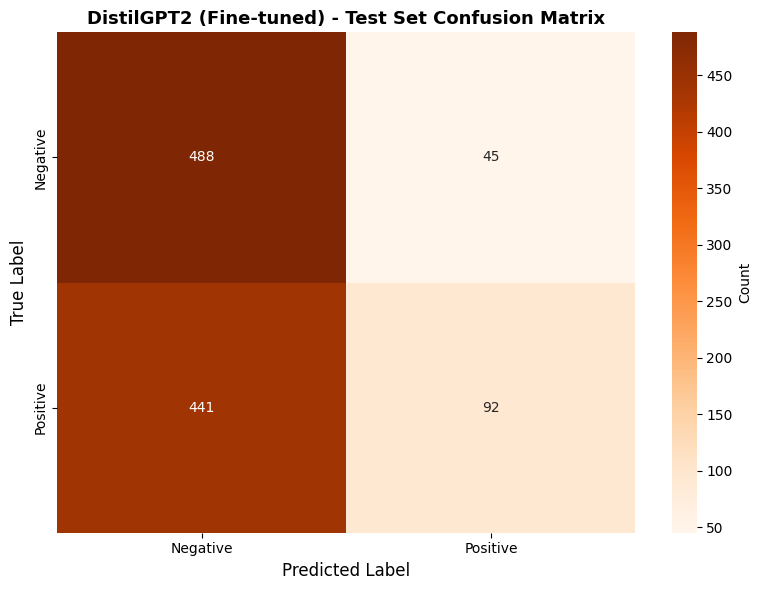


Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      0.92      0.67       533
    Positive       0.67      0.17      0.27       533

    accuracy                           0.54      1066
   macro avg       0.60      0.54      0.47      1066
weighted avg       0.60      0.54      0.47      1066


✓ Model removed from memory

GENERATIVE MODELS SUMMARY (TEST SET)


NameError: name 'smol_prompt_predictions' is not defined

In [17]:
#  Test Evaluation (DistilGPT2 Fine-tuned)

print("="*70)
print("DISTILGPT2 FINE-TUNED - TEST SET EVALUATION")
print("="*70)

# Load best fine-tuned model
model_gpt2_finetuned = AutoModelForCausalLM.from_pretrained(
    "./gpt2_ft_best_model",
    torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    device_map="auto"
)
tokenizer_gpt2_finetuned = AutoTokenizer.from_pretrained("./gpt2_ft_best_model")

print("✓ Best fine-tuned model loaded")

# =============================================================================
# EVALUATION FUNCTION
# =============================================================================

def evaluate_finetuned_gpt2(model, tokenizer, dataset_split):
    """Evaluate fine-tuned DistilGPT2"""
    
    predictions = []
    true_labels = []
    failed_parses = 0
    
    print(f"\nEvaluating on {len(dataset_split)} examples...")
    
    for example in tqdm(dataset_split):
        text = example['text']
        true_label = example['label']
        
        # Create prompt (same format as training)
        prompt = f"Review: {text}\nSentiment:"
        
        # Generate
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=200).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id
            )
        
        # Decode
        generated = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).strip()
        
        # Parse
        predicted_label = parse_sentiment(generated)
        
        if predicted_label is None:
            failed_parses += 1
            predicted_label = 0
        
        predictions.append(predicted_label)
        true_labels.append(true_label)
    
    # Calculate metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean()
    
    neg_mask = true_labels == 0
    pos_mask = true_labels == 1
    neg_accuracy = (predictions[neg_mask] == true_labels[neg_mask]).mean()
    pos_accuracy = (predictions[pos_mask] == true_labels[pos_mask]).mean()
    
    results = {
        'accuracy': accuracy,
        'negative_accuracy': neg_accuracy,
        'positive_accuracy': pos_accuracy,
        'failed_parses': failed_parses,
        'failed_parse_rate': failed_parses / len(dataset_split),
        'predictions': predictions,
        'true_labels': true_labels
    }
    
    return results

# Evaluate on test set
test_results_gpt2_ft = evaluate_finetuned_gpt2(
    model_gpt2_finetuned,
    tokenizer_gpt2_finetuned,
    dataset['test']
)

print(f"\n{'='*70}")
print("FINAL TEST RESULTS:")
print(f"{'='*70}")
print(f"Accuracy: {test_results_gpt2_ft['accuracy']:.4f}")
print(f"Negative Accuracy: {test_results_gpt2_ft['negative_accuracy']:.4f}")
print(f"Positive Accuracy: {test_results_gpt2_ft['positive_accuracy']:.4f}")
print(f"Failed Parses: {test_results_gpt2_ft['failed_parses']} ({test_results_gpt2_ft['failed_parse_rate']:.2%})")
print(f"{'='*70}")

# Store for error analysis
gpt2_ft_predictions = {
    'model': 'DistilGPT2 (fine-tuned)',
    'predictions': test_results_gpt2_ft['predictions'],
    'true_labels': test_results_gpt2_ft['true_labels'],
    'accuracy': test_results_gpt2_ft['accuracy'],
    'failed_parses': test_results_gpt2_ft['failed_parses']
}

with open('gpt2_ft_predictions.pkl', 'wb') as f:
    pickle.dump(gpt2_ft_predictions, f)

print("\n✓ Predictions saved for error analysis")

# =============================================================================
# COMPARISON: PROMPTING vs FINE-TUNING
# =============================================================================

print("\n" + "="*70)
print("DISTILGPT2 COMPARISON: PROMPTING vs FINE-TUNING")
print("="*70)
print(f"Prompting (2-shot):    {gpt2_prompt_predictions['accuracy']:.4f} accuracy")
print(f"Fine-tuning:           {test_results_gpt2_ft['accuracy']:.4f} accuracy")
print(f"Difference:            {(test_results_gpt2_ft['accuracy'] - gpt2_prompt_predictions['accuracy']):.4f}")
if test_results_gpt2_ft['accuracy'] < gpt2_prompt_predictions['accuracy']:
    print("⚠️  Fine-tuning underperformed prompting for DistilGPT2")
elif test_results_gpt2_ft['accuracy'] > gpt2_prompt_predictions['accuracy']:
    print("✓ Fine-tuning outperformed prompting for DistilGPT2")
print("="*70)

# Confusion Matrix
cm = confusion_matrix(test_results_gpt2_ft['true_labels'], 
                      test_results_gpt2_ft['predictions'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('DistilGPT2 (Fine-tuned) - Test Set Confusion Matrix',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('distilgpt2_ft_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(test_results_gpt2_ft['true_labels'], 
                           test_results_gpt2_ft['predictions'],
                           target_names=['Negative', 'Positive']))

# Cleanup
del model_gpt2_finetuned
torch.cuda.empty_cache()
print("\n✓ Model removed from memory")

# =============================================================================
# SUMMARY: ALL GENERATIVE MODELS SO FAR
# =============================================================================

print("\n" + "="*70)
print("GENERATIVE MODELS SUMMARY (TEST SET)")
print("="*70)
print(f"SmolLM Prompting:      {smol_prompt_predictions['accuracy']:.4f}")
print(f"SmolLM Fine-tuned:     {smol_ft_predictions['accuracy']:.4f}")
print(f"DistilGPT2 Prompting:  {gpt2_prompt_predictions['accuracy']:.4f}")
print(f"DistilGPT2 Fine-tuned: {test_results_gpt2_ft['accuracy']:.4f}")
print("="*70)
print("\n✓ All generative models complete!")
print("Next: BERT models (Section 5) - these should perform much better!")

---

## 5. Fine-tuning a bidirectional model

### 5.1. Model training

In [6]:
# Your code to train the transformer-based model on the training set and evaluate the performance on the validation set here

### 5.2 Hyperparameter optimization

In [7]:
# Your code for hyperparameter optimization here

### 5.3 Evaluation on test set

In [8]:
# Your code to evaluate the final model on the test set here

---

## 6. Bonus Task (optional)

Repeat sections 3 through 5 here for a second generative and a second bidirectional model. When summarizing your results below (Section 7), include also comparison of the two generative models and the two bidirectional models.

---

## 7. Results and summary

### 7.1 Corpus insights

(Briefly discuss what you learned about the corpus and its annotation)

### 7.2 Results

(Briefly summarize your results)

### 7.3 Relation to random baseline / expected performance / state of the art

(Compare your results with the random and state-of-the-art performance)

---

## 8 Error analysis (group projects only)

(Present the error analysis results here)